In [1]:
!pip install split-folders

In [2]:
import pandas as pd
import os
import zipfile as zf
import splitfolders
from imutils import paths
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Prepare dataset


In [3]:
!gdown 1P6lWTRuNl_OqmQR-Yq9XkWXeNaofd1gM

Downloading...
From (original): https://drive.google.com/uc?id=1P6lWTRuNl_OqmQR-Yq9XkWXeNaofd1gM
From (redirected): https://drive.google.com/uc?id=1P6lWTRuNl_OqmQR-Yq9XkWXeNaofd1gM&confirm=t&uuid=987ac509-b792-4f24-94dd-9905a5c4440b
To: /content/trash_images_final-again.zip
100% 134M/134M [00:02<00:00, 62.3MB/s]


In [4]:
files = zf.ZipFile("/content/trash_images_final-again.zip",'r')
files.extractall()
files.close()
os.listdir(os.path.join(os.getcwd(),"trash_images_final"))

['plastic', 'metal', 'cardboard', 'organic', 'paper', 'glass']

In [5]:
splitfolders.ratio("/content/trash_images_final", output="/content/data",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 4607 files [00:02, 1679.36 files/s]


In [6]:
# Get the paths for the train and validation directories
train_dir = os.path.join(os.getcwd(), "data/train")
val_dir = os.path.join(os.getcwd(), "data/val")

# Get a list of all the folders in the train and validation directories
train_folders = os.listdir(train_dir)
val_folders = os.listdir(val_dir)

# Print the number of directories in each dataset
print(f"Number of directories in train dataset: {len(train_folders)}")
print(f"Number of directories in validation dataset: {len(val_folders)}")

# Print the contents of each folder and the number of files in each folder
print("\nTrain data:")
for folder in train_folders:
  folder_path = os.path.join(train_dir, folder)
  files = os.listdir(folder_path)
  print(f"- {folder}: {len(files)}")

print("\nValidation data:")
for folder in val_folders:
  folder_path = os.path.join(val_dir, folder)
  files = os.listdir(folder_path)
  print(f"- {folder}: {len(files)}")
# Get the paths for the train and validation directories
train_dir = os.path.join(os.getcwd(), "data/train")
val_dir = os.path.join(os.getcwd(), "data/val")

# Get a list of all the folders in the train and validation directories
train_folders = os.listdir(train_dir)
val_folders = os.listdir(val_dir)

total_train = len(list(paths.list_images(train_dir)))
total_val = len(list(paths.list_images(val_dir)))
print("\nTotal training images:", total_train)
print("Total validation images:", total_val)



Number of directories in train dataset: 6
Number of directories in validation dataset: 6

Train data:
- plastic: 621
- metal: 620
- cardboard: 600
- organic: 616
- paper: 603
- glass: 624

Validation data:
- plastic: 156
- metal: 156
- cardboard: 150
- organic: 154
- paper: 151
- glass: 156

Total training images: 3684
Total validation images: 923


# Create Model

In [7]:
base_model=tf.keras.applications.MobileNet(weights='imagenet',
                                           include_top=False,
                                           input_shape=(224, 224, 3))

17225924/17225924 [==============================] - 0s 0us/step


In [8]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [9]:
model =  Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

In [10]:
for layer in base_model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0

In [12]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                    shear_range=0.2,
                                    rotation_range=40,
                                    width_shift_range=0.3,
                                    height_shift_range=0.3,
                                    zoom_range=0.3,
                                    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen  = ImageDataGenerator( rescale = 1.0/255.,
                                    rotation_range=30,
                                    width_shift_range=0.3,
                                    height_shift_range=0.3,
                                    zoom_range=0.3,
                                    horizontal_flip=True)

In [13]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                    target_size=(224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(val_dir,
                                                         batch_size=16,
                                                         class_mode='categorical',
                                                         color_mode='rgb',
                                                         shuffle=False,
                                                         target_size=(224, 224))

Found 3684 images belonging to 6 classes.
Found 923 images belonging to 6 classes.


In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00001),
              metrics=['accuracy'])

H = model.fit(train_generator,
              steps_per_epoch=total_train // 16,
              validation_data=validation_generator,
              validation_steps=total_val // 16,
              epochs=60)

Epoch 1/60
230/230 [==============================] - 106s 353ms/step - loss: 1.7538 - accuracy: 0.2702 - val_loss: 1.3593 - val_accuracy: 0.5746
Epoch 2/60
230/230 [==============================] - 74s 322ms/step - loss: 1.4038 - accuracy: 0.4591 - val_loss: 0.9921 - val_accuracy: 0.7007
Epoch 3/60
230/230 [==============================] - 79s 345ms/step - loss: 1.1370 - accuracy: 0.5728 - val_loss: 0.7765 - val_accuracy: 0.7566
Epoch 4/60
230/230 [==============================] - 82s 355ms/step - loss: 0.9433 - accuracy: 0.6499 - val_loss: 0.6441 - val_accuracy: 0.7807
Epoch 5/60
230/230 [==============================] - 81s 351ms/step - loss: 0.8386 - accuracy: 0.6889 - val_loss: 0.5530 - val_accuracy: 0.8103
Epoch 6/60
230/230 [==============================] - 75s 328ms/step - loss: 0.7323 - accuracy: 0.7268 - val_loss: 0.4999 - val_accuracy: 0.8125
Epoch 7/60
230/230 [==============================] - 72s 312ms/step - loss: 0.6797 - accuracy: 0.7552 - val_loss: 0.4547 - val_a

#Evaluasi Model

Text(0.5, 1.0, 'Training and validation loss')

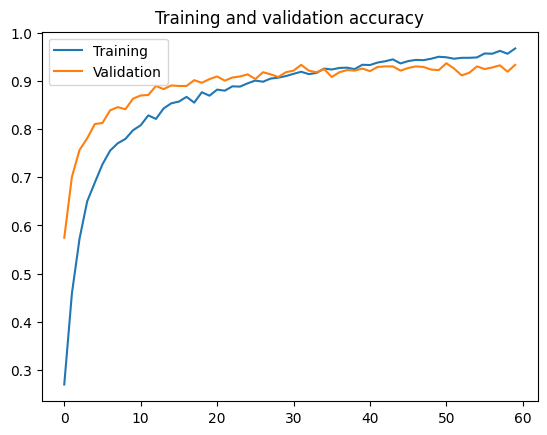

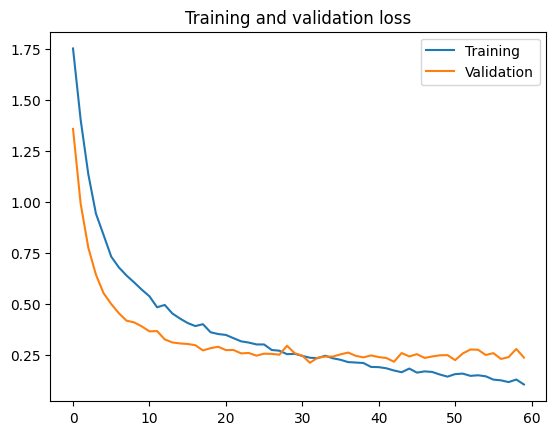

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = H.history[    'accuracy' ]
val_acc  = H.history['val_accuracy' ]
loss     = H.history[    'loss' ]
val_loss = H.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

In [16]:
# Get the predictions for the validation data
y_pred = model.predict(validation_generator)
# Convert the predictions to class labels
y_pred = np.argmax(y_pred, axis=1)
# Print the classification report
print(classification_report(validation_generator.classes, y_pred))

58/58 [==============================] - 15s 242ms/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       150
           1       0.88      0.92      0.90       156
           2       0.92      0.88      0.90       156
           3       0.94      0.99      0.97       154
           4       0.94      0.95      0.94       151
           5       0.92      0.85      0.89       156

    accuracy                           0.93       923
   macro avg       0.93      0.93      0.93       923
weighted avg       0.93      0.93      0.93       923



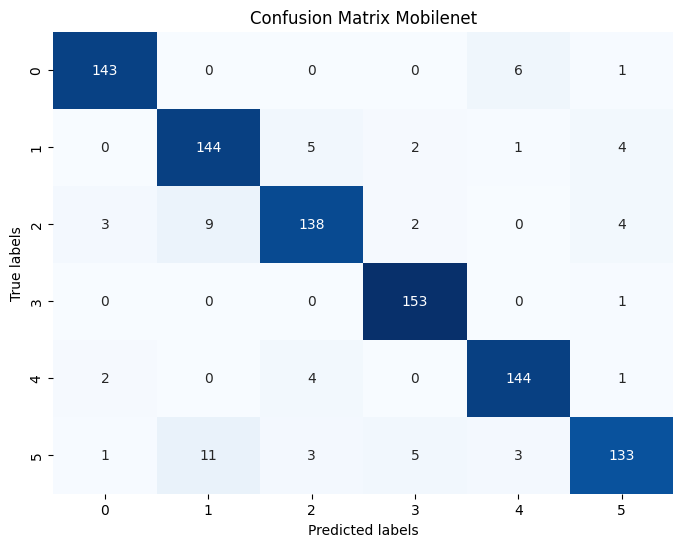

In [22]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

# Extract true labels from the validation generator (to match y_pred)
y_true = validation_generator.classes

# y_pred is already calculated in a previous cell, no need for argmax here
plot_confusion_matrix(y_true, y_pred, 'Confusion Matrix Mobilenet')

#Save Model and Convert Model To Tensorflow Json

In [23]:
import tensorflow as tf

print('\u2022 Using TensorFlow Version:', tf.__version__)

• Using TensorFlow Version: 2.15.0


In [24]:
pip install tensorflowjs --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.0 MB/s eta 0:00:00


In [27]:
# tensorflow.js converter to convert the saved Keras model into JSON format.
model.save('model_wastify.h5')
saved_model_path = "/content/model_wastify.h5"
!tensorflowjs_converter --input_format=keras {saved_model_path} ./
!zip modelwastify.zip *.bin model.json

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2024-06-21 06:18:27.058460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  adding: group1-shard1of7.bin (deflated 8%)
  adding: group1-shard2of7.bin (deflated 8%)
  adding: group1-shard3of7.bin (deflated 8%)
  adding: group1-shard4of7.bin (deflated 7%)
  adding: group1-shard5of7.bin (deflated 7%)
  adding: group1-shard6of7.bin (deflated 7%)
  adding: group1-shard7of7.bin (deflated 7%)
  adding: model.json (deflated 95%)
